# Epidemiology: Phylogen + Aggregate observations


This notebook demonstrates how to use the [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) to infer epidemiological parameters based on both aggregate infection data and phylogenetic data from sequenced viral genomes. We will generally follow the analysis of [(Li & Ayscue 2020)](https://www.medrxiv.org/content/10.1101/2020.05.05.20092098v1).

In [1]:
import io
import re
import datetime
import urllib.request

import torch
from Bio import Phylo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist
from pyro.contrib.epidemiology.models import SuperspreadingSEIRModel

%matplotlib inline
pyro.enable_validation(True)
torch.set_default_dtype(torch.double)
torch.multiprocessing.set_start_method("spawn")
torch.set_printoptions(precision=2)
print(torch.__version__)
print(pyro.__version__)

1.5.0
1.3.1+4986f826


In [2]:
def download(url):
    res = urllib.request.urlopen(url)
    return io.StringIO(res.read().decode("utf-8"))

In [3]:
region = "california"
url_phylogeny = "https://github.com/czbiohub/EpiGen-COVID19/raw/master/files/{}_timetree.nexus"
with download(url_phylogeny.format(region)) as f:
    for phylogeny in Phylo.parse(f, "nexus"):
        break

In [4]:
# Fix a parsing error for whereby internal nodes interpret .name as .confidence
for clade in phylogeny.find_clades():
    if clade.confidence:
        clade.name = clade.confidence
        clade.confidence = None

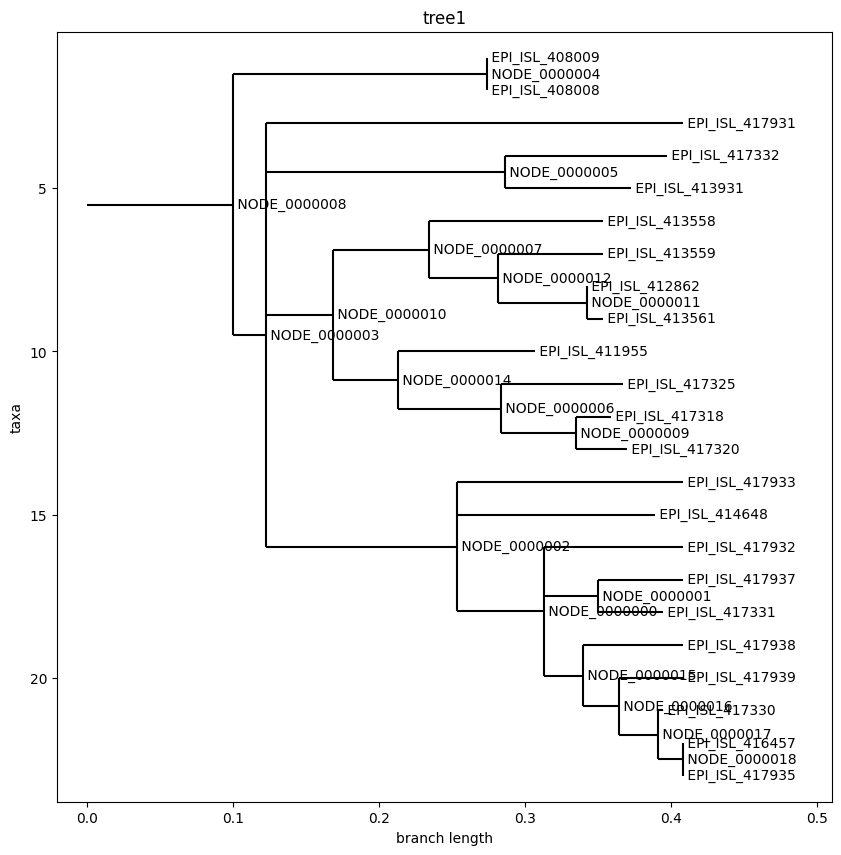

In [5]:
Phylo.draw(phylogeny, do_show=False)
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(10)

We can load the timeseries file using Pandas.

In [6]:
url_timeseries = ("https://github.com/czbiohub/EpiGen-COVID19/raw/master/files/"
                  "{}_timeseries.txt")
df = pd.read_csv(download(url_timeseries.format(region)), sep="\t")
print(len(df))
df.head()

57


,date,new_cases
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1


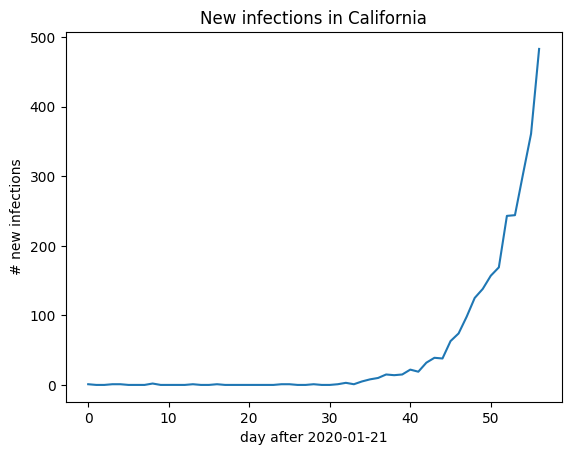

In [7]:
plt.plot(df["new_cases"])
plt.xlabel("day after {}".format(df["date"][0]))
plt.ylabel("# new infections")
plt.title("New infections in {}".format(region.capitalize()));

## Converting data inputs to PyTorch tensors

We'll need to convert the timeseres from pandas dataframe to torch tensor.

In [8]:
start_date = datetime.datetime.strptime(df.date[0], "%Y-%m-%d")
start_date

datetime.datetime(2020, 1, 21, 0, 0)

In [9]:
start_days_after_2020 = (start_date - datetime.datetime(2020, 1, 1, 0, 0)).days
start_days_after_2020

20

In [10]:
new_cases = list(df["new_cases"])
if new_cases[-1] == 0:
    new_cases.pop(-1)  # ignore a final empty observation
new_cases = torch.tensor(new_cases, dtype=torch.double)
print(new_cases.sum())

tensor(2690.)


In [11]:
leaf_times = []
coal_times = []
for clade in phylogeny.find_clades():
    date_string = re.search(r"date=(\d\d\d\d\.\d\d)", clade.comment).group(1)
    days_after_2020 = (float(date_string) - 2020) * 365.25
    time = days_after_2020 - start_days_after_2020

    num_children = len(clade)
    if num_children == 0:
        leaf_times.append(time)
    else:
        # Pyro expects binary coalescent events, so we split n-ary events
        # into n-1 separate binary events.
        for _ in range(num_children - 1):
            coal_times.append(time)
assert len(leaf_times) == 1 + len(coal_times)

leaf_times = torch.tensor(leaf_times, dtype=torch.double)
coal_times = torch.tensor(coal_times, dtype=torch.double)

Let's visualize this aggregate data.

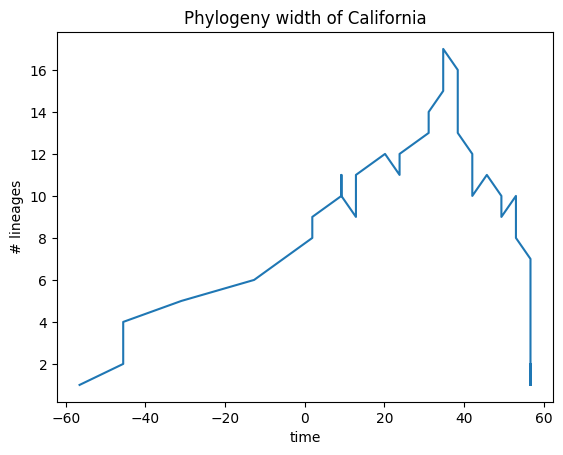

In [12]:
times = torch.cat([coal_times, leaf_times])
signs = torch.cat([-torch.ones_like(coal_times), torch.ones_like(leaf_times)])
times, index = times.sort(0)
signs = signs[index]
lineages = signs.flip([0]).cumsum(0).flip([0])

plt.plot(times, lineages)
plt.xlabel("time")
plt.ylabel("# lineages")
plt.title("Phylogeny width of {}".format(region.capitalize()));

## Fitting a model

The [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) module provides a number of simple example models. We can start by training one of those, say an [SuperspreadingSEIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.seir.SuperspreadingSEIRModel).

In [ ]:
%%time
model = SuperspreadingSEIRModel(population=int(39e6),
                                incubation_time=5.5,
                                recovery_time=14.,
                                data=new_cases,
                                leaf_times=leaf_times,
                                coal_times=coal_times)

pyro.set_rng_seed(20200615)
mcmc = model.fit(warmup_steps=200, num_samples=800, haar_full_mass=7,
                 num_chains=4, jit_compile=True)

INFO 	 Running inference...


In [ ]:
mcmc.summary()

In [ ]:
def plot_globals(samples):
    names = sorted(k for k, v in model.samples.items() if v.shape[1:].numel() == 1)

    # Plot individual histograms.
    fig, axes = plt.subplots(len(names), 1, figsize=(5, 2.5 * len(names)))
    for ax, name in zip(axes, names):
        mean = samples[name].mean().item()
        std = samples[name].std().item()
        ax.set_title("{} = {:0.3g} \u00B1 {:0.3g}".format(name, mean, std))
        sns.distplot(samples[name].reshape(-1), ax=ax)
        ax.set_yticks(())
    plt.tight_layout()
    
    # Plot pairwise joint distributions for selected variables.
    covariates = [(name, samples[name]) for name in names]
    N = len(covariates)
    fig, axes = plt.subplots(N, N, figsize=(6, 6), sharex="col", sharey="row")
    for i in range(N):
        axes[i][0].set_ylabel(covariates[i][0])
        axes[0][i].set_xlabel(covariates[i][0])
        axes[0][i].xaxis.set_label_position("top")
        for j in range(N):
            ax = axes[i][j]
            ax.set_xticks(())
            ax.set_yticks(())
            ax.scatter(covariates[j][1], -covariates[i][1],
                       lw=0, color="darkblue", alpha=0.3)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
plot_globals(model.samples)

## Forecasting

In [ ]:
forecast = 14
samples = model.predict(forecast=forecast)

In [ ]:
def plot_series(model, samples):
    obs = model.data
    S2E = samples["S2E"]
    num_samples, T = S2E.shape
    median = S2E.median(dim=0).values
    pred = samples["obs"].median(dim=0).values.squeeze()[model.duration:]
    print("Median prediction of new infections (starting on day 0):\n{}"
          .format(" ".join(map(str, map(int, median)))))

    plt.figure()
    time = torch.arange(T)
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:model.duration], obs, "k.", label="observed")
    plt.plot(time[model.duration:], pred, "k+", label="predicted")
    plt.axvline(model.duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(1, None)
    plt.yscale("log")
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("Predicted new infections (absent intervention)")
    plt.legend(loc="upper left")
    plt.tight_layout()

In [ ]:
plot_series(model)